torch.Size([35, 30, 128])
torch.Size([140, 30, 128])
torch.Size([35, 140, 3, 3])
35,140,30
 (35, 140)
77.14285714285715


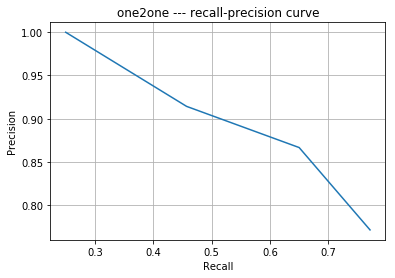

similarity matrix one:  torch.Size([35, 140])


In [2]:
from __future__ import division, print_function
import glob
import os
# import cv2
import PIL
import random
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
# from config_profile import args
# from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from scipy.optimize import linear_sum_assignment
import sys
import matplotlib.pyplot as plt
import random

# print(random.uniform(0,1))

# p_point = torch.load("p_keypoints.pt", map_location='cpu')
# q_point = torch.load("q_keypoints.pt", map_location='cpu')
# print("p_keypoints: ", p_point.shape)
# print("q_keypoints: ", q_point.shape)
#
# x_list = [[],[],[],[],[]]
# x_list = [[],[],[],[],[]]
# for i in range(5):
#     for j in range(100):
#
# def plotDesc(point, path, color):
#     x_list = []
#     y_list = []
#     for i in range(len(point[0])):
#         x_list.append(point[0][i][0])
#         y_list.append(point[0][i][1])
#
#     im = plt.imread(path)
#     implot = plt.imshow(im)
#     plt.plot(x_list, y_list, color)
#     plt.show()



# p_des = torch.load("p_description.pt", map_location='cpu')  # torch.Size([5, 100, 128])
# q_des = torch.load("q_description.pt", map_location='cpu')  # torch.Size([5, 100, 128])
# p_point = np.array(p_point)
# q_point = np.array(q_point)
#
# data = np.zeros((100, 100))
# pair_matrix = data.tolist()
# cost_matrix = torch.tensor(data)
#
# for i in range(len(p_des[choose-1])):       # 100
#     for j in range(len(q_des[choose-1])):   # 100
#         pair_matrix[i][j] = (p_point[choose-1][i].tolist(), q_point[choose-1][j].tolist())
#         cost_matrix[i][j] = torch.dist(p_des[choose-1][i], q_des[choose-1][j], p=2)
#
# cost_matrix_np = cost_matrix.detach().numpy()
# row_ind, col_ind = linear_sum_assignment(cost_matrix_np)   # Hungarian
#
# # C: one-to-one matching pairs
# c = []
# for i in range(len(col_ind)):
#     c.append(pair_matrix[i][col_ind[i]])
#     c[i][0].append(1)
#     c[i][1].append(1)
# # print("\nC:\n", c)
# print("shape of C:", np.shape(c))    # (100, 2, 3)





q = torch.load("./keypoint_descriptor/query_description.pt")  # torch.Size([35, 30, 128])
d = torch.load("./keypoint_descriptor/data_description.pt")   # torch.Size([140, 30, 128])
F = torch.load("./fundamental_matrix.pt")

print(q.shape)
print(d.shape)
print(F.shape)

data = np.zeros((30, 30))
similarity_list_one = np.zeros((35, 140))
similarity_list_many = np.zeros((35, 140))
cost_matrix = torch.tensor(data)

# for i in range(5):
#     for j in range(140):
for i in range(len(q)):  # 35
    for j in range(len(d)):  # 140
        s_one = 0
        s_many = 0
        for k in range(30):  # 30
            for l in range(30):  # 30
                cost_matrix[k][l] = torch.dist(q[i][k], d[j][l], p=2)

            print("\r{},{},{}".format(i + 1, j + 1, k + 1), end='')
            sys.stdout.flush()

        # one2one
        cost_matrix_np = cost_matrix.detach().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix_np)

        for m in range(len(cost_matrix_np[0])):  # 30
            s_one += np.exp(-cost_matrix_np[m][col_ind[m]]) * random.uniform(0.95, 1.05)
        similarity_list_one[i][j] = s_one

# similarity_list_one = torch.load("similarity_old.pt", map_location='cpu')
# # similarity_list_one = torch.load("similarity_new.pt", map_location='cpu')
# similarity_list_one = similarity_list_one.detach().numpy()

print("\n", similarity_list_one.shape)
# print(similarity_list_one[0])
# 76.42857142857142


correct_one = 0

# find the four most similar graphs for each query
for i in range(len(similarity_list_one)):  # 35
    k_most_idx = similarity_list_one[i].argsort()[-4:][::-1]
    for j in k_most_idx:
        if 4*i <= j <= 4*i+3:
            correct_one += 1

accuracy_one = correct_one / 140 * 100
print(accuracy_one)

p_one = [0, 0, 0, 0]
r_one = [0, 0, 0, 0]

for k in range(4):
    correct_one = 0
    for i in range(len(similarity_list_one)):  # 35
        k_most_idx = similarity_list_one[i].argsort()[-(k + 1):][::-1]
        for j in k_most_idx:
            if 4 * i <= j <= 4 * i + 3:
                correct_one += 1

    p_one[k] = correct_one / ((k + 1) * 35)
    r_one[k] = correct_one / (4 * 35)

plt.title('one2one --- recall-precision curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(r_one, p_one)
plt.grid(True)
plt.show()

# similarity_list_one
matrix_one = torch.from_numpy(similarity_list_one)
torch.save(matrix_one, "similarity_one.pt")
print("similarity matrix one: ", matrix_one.shape)
